In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
import pandas as pd
import glob
import os

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import statistics
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score,precision_score, recall_score, f1_score

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [33]:
df = pd.read_csv("yeast2vs4.csv")

print("\n\nSample Data:")
print("============\n")
print(df.head(20))



Sample Data:

     mcg   gvh   alm   mit  erl  pox   vac   nuc     class
0   0.51  0.40  0.56  0.17  0.5  0.5  0.49  0.22  negative
1   0.40  0.39  0.60  0.15  0.5  0.0  0.58  0.30  negative
2   0.40  0.42  0.57  0.35  0.5  0.0  0.53  0.25  negative
3   0.46  0.44  0.52  0.11  0.5  0.0  0.50  0.22  negative
4   0.47  0.39  0.50  0.11  0.5  0.0  0.49  0.40  negative
5   0.45  0.40  0.50  0.16  0.5  0.0  0.50  0.22  negative
6   0.43  0.44  0.48  0.22  0.5  0.0  0.51  0.22  negative
7   0.73  0.63  0.42  0.30  0.5  0.0  0.49  0.22  negative
8   0.43  0.53  0.52  0.13  0.5  0.0  0.55  0.22  negative
9   0.46  0.53  0.52  0.15  0.5  0.0  0.58  0.22  negative
10  0.57  0.47  0.60  0.18  0.5  0.0  0.51  0.22  negative
11  0.38  0.61  0.61  0.12  0.5  0.0  0.53  0.47  negative
12  0.40  0.45  0.57  0.18  0.5  0.0  0.56  0.26  negative
13  0.48  0.39  0.51  0.21  0.5  0.0  0.52  0.28  negative
14  0.64  0.59  0.56  0.23  0.5  0.0  0.46  0.22  negative
15  0.64  0.56  0.56  0.22  0.5  0.0  0.

In [34]:
def count_digit(num):
    count = 0
    while num != 0:
        num //= 10
        count += 1
    return count

def check_shape(df):
    rows, cols = df.shape
    print("\nNumber or rows in dataset: {}".format(rows))
    print("==========================={}".format(count_digit(rows)*'='))
    print("\nNumber or columns in dataset: {}".format(cols))
    print("=============================={}".format(count_digit(cols)*'='))
    
def modelEvaluation(predictions, y_test_set, model_name, classes):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
    print ("\nClassification report : \n", classification_report(y_test_set, predictions, target_names = classes))
#     print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set,predictions))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True,yticklabels=classes, xticklabels=classes, fmt='g',cmap='jet')
    
    plt.title('Confusion Matrix of {}'.format(model_name))
    plt.xlabel('predicted Labels')
    plt.ylabel('Actual Labels')
#     plt.tight_layout()
    plt.show()
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions,average='macro'),
              recall_score(y_test_set, predictions,average='macro'),f1_score(y_test_set, predictions,average='macro')]#store results of model
    return results

In [35]:
# Understand Sample Data

print("\n\nAttributes in Sample Data:")
print("==========================\n")

print(df.columns)

print("\n\nNumber of Instances in Sample Data:",len(df.index))
print("===================================={}\n".format(count_digit(len(df.index))*'='))



Attributes in Sample Data:

Index(['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class'], dtype='object')


Number of Instances in Sample Data: 514



negative    463
positive     51
Name: class, dtype: int64


(array([0, 1]), [Text(0, 0, 'negative'), Text(1, 0, 'positive')])

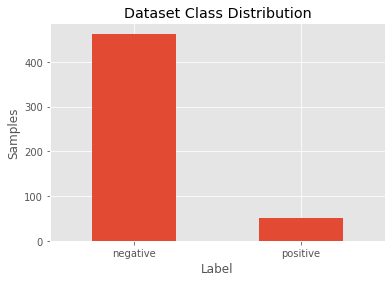

In [36]:
# print(df.label.value_counts(), "\n")

print(df['class'].value_counts())
plt.style.use('ggplot')
df.value_counts('class').plot(kind='bar')
plt.title('Dataset Class Distribution')
plt.xlabel('Label')
plt.ylabel('Samples')
plt.xticks(rotation = 0)

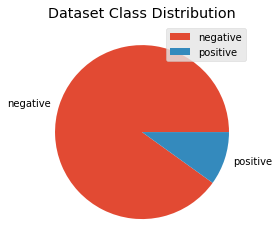

In [37]:
classes_counts = df.value_counts('class')
values = np.array(classes_counts)
mylabels = list(classes_counts.index)

plt.pie(values, labels = mylabels)
plt.legend()
plt.title('Dataset Class Distribution')
plt.show() 

In [38]:
classes = list(df['class'].unique())
print(classes)

le = LabelEncoder()
df['encoded_class'] = le.fit_transform(df['class'])
mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(mapping)

['negative', 'positive']
{'negative': 0, 'positive': 1}


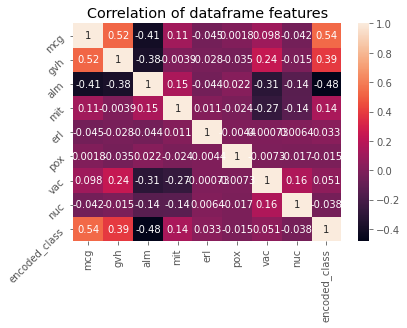

In [39]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.yticks(rotation=45)
plt.title("Correlation of dataframe features")
plt.show()

In [40]:
for column in  df.columns:
    count = (df[column] == 0).sum()
    print('Count of zeros in Column  {} : '.format(column), count)

Count of zeros in Column  mcg :  0
Count of zeros in Column  gvh :  0
Count of zeros in Column  alm :  0
Count of zeros in Column  mit :  1
Count of zeros in Column  erl :  0
Count of zeros in Column  pox :  513
Count of zeros in Column  vac :  0
Count of zeros in Column  nuc :  1
Count of zeros in Column  class :  0
Count of zeros in Column  encoded_class :  463


In [41]:
input_features = list(df.columns[0:-2])
X = df[input_features]
y = df['encoded_class']

In [42]:
# df = df.drop(['pox'], axis=1)
# print(df.shape)
# df.head()

In [43]:
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,class,encoded_class
0,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,negative,0
1,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,negative,0
2,0.40,0.42,0.57,0.35,0.5,0.0,0.53,0.25,negative,0
3,0.46,0.44,0.52,0.11,0.5,0.0,0.50,0.22,negative,0
4,0.47,0.39,0.50,0.11,0.5,0.0,0.49,0.40,negative,0


Feature: 0, Score: 4.06002
Feature: 1, Score: 1.76278
Feature: 2, Score: -4.37534
Feature: 3, Score: 0.77815
Feature: 4, Score: -0.75416
Feature: 5, Score: -0.02992
Feature: 6, Score: -0.82264
Feature: 7, Score: -0.75670


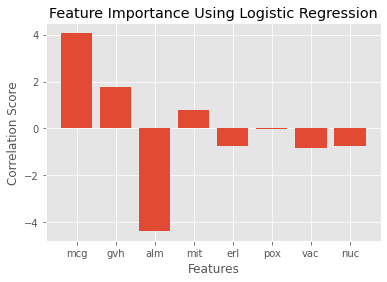

In [44]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot




# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar(X.columns, importance)
plt.title("Feature Importance Using Logistic Regression")
plt.xlabel("Features")
plt.ylabel("Correlation Score")
pyplot.show()

In [45]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [46]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 463, 1: 463})


In [48]:
X_res = pd.DataFrame(X_res, columns = X.columns)
print(X_res.shape)
X_res.head()

(926, 8)


,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22
1,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30
2,0.40,0.42,0.57,0.35,0.5,0.0,0.53,0.25
3,0.46,0.44,0.52,0.11,0.5,0.0,0.50,0.22
4,0.47,0.39,0.50,0.11,0.5,0.0,0.49,0.40


In [49]:
def split_df(X, y, split_index):
    if split_index==0:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
        return X_train,X_test,y_train,y_test
    if split_index==1:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
        X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.1)
        return X_train, X_test, X_val, y_train, y_test, y_val

In [50]:
split_index = 0
split = ['train_test', 'train_test_val']

X_train,X_test,y_train,y_test = split_df(X_res, y_res, split_index)

In [51]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(740, 8)
(186, 8)
740
186


In [52]:
classes = list(df['class'].unique())
collect_results_of_all_model= {
    'Metrics':['accuracy','precision','recall','f1-score']
} #dic form store results of all models

In [59]:
from sklearn.linear_model import LinearRegression

lr_classifier =  LinearRegression()
lr_classifier.fit(X_train, y_train)

preds = lr_classifier.predict(X_test)

In [60]:
train_preds = lr_classifier.predict(X_train)
y_pred = []
for pred in train_preds:
    if pred >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
accuracy_score(y_train, y_pred)

0.9297297297297298

In [61]:
y_pred = []
for pred in preds:
    if pred >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

========== Linear Regression ==========

Accuracy on validation set: 0.9032

Classification report : 
              precision    recall  f1-score   support

   negative       0.90      0.88      0.89        85
   positive       0.90      0.92      0.91       101

avg / total       0.90      0.90      0.90       186



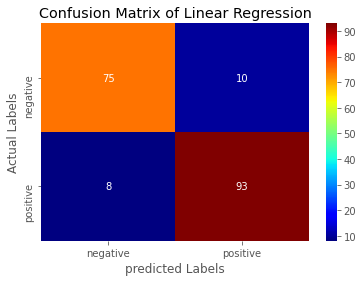

In [62]:
LR_res=modelEvaluation(y_pred, y_test, 'Linear Regression', classes)
collect_results_of_all_model["Linear Regression"] = LR_res

In [64]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state=0)
lr_classifier.fit(X_train, y_train)

predictions = lr_classifier.predict(X_train)
print(accuracy_score(y_train, predictions))
preds = lr_classifier.predict(X_test)

0.9054054054054054


========== Logistic Regression ==========

Accuracy on validation set: 0.8817

Classification report : 
              precision    recall  f1-score   support

   negative       0.91      0.85      0.87        91
   positive       0.86      0.92      0.89        95

avg / total       0.88      0.88      0.88       186



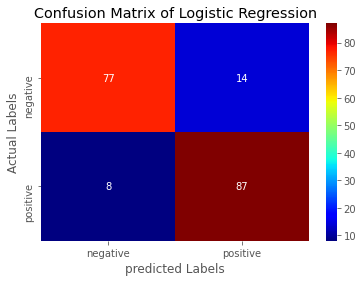

In [65]:
LR_res=modelEvaluation(y_test, preds, 'Logistic Regression', classes)
collect_results_of_all_model["Logistic Regression"] = LR_res

In [66]:
from sklearn.svm import SVC

SVC_classifier = SVC(kernel='linear')
SVC_classifier.fit(X_train,y_train)

predictions = SVC_classifier.predict(X_train)
print(accuracy_score(y_train, predictions))
preds = SVC_classifier.predict(X_test)

0.9108108108108108


========== SVM ==========

Accuracy on validation set: 0.8978

Classification report : 
              precision    recall  f1-score   support

   negative       0.86      0.93      0.89        85
   positive       0.94      0.87      0.90       101

avg / total       0.90      0.90      0.90       186



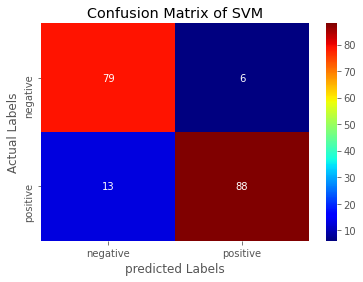

In [67]:
SVC_res=modelEvaluation(preds, y_test, 'SVM', classes)
collect_results_of_all_model["SVC"] = SVC_res

In [70]:
from sklearn.neighbors import KNeighborsClassifier

neighbors_clf = KNeighborsClassifier(n_neighbors=5,)
neighbors_clf.fit(X_train,y_train)

KNN_preds = neighbors_clf.predict(X_test)

========== KNN ==========

Accuracy on validation set: 0.9677

Classification report : 
              precision    recall  f1-score   support

   negative       1.00      0.93      0.96        85
   positive       0.94      1.00      0.97       101

avg / total       0.97      0.97      0.97       186



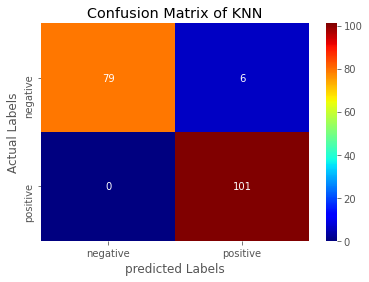

In [71]:
KNN_res = modelEvaluation(KNN_preds,y_test,'KNN',classes)
collect_results_of_all_model["KNN"] = KNN_res

In [72]:
SVC_classifier = SVC(kernel='rbf')
SVC_classifier.fit(X_train,y_train)

preds = SVC_classifier.predict(X_test)

========== SVM ==========

Accuracy on validation set: 0.8871

Classification report : 
              precision    recall  f1-score   support

   negative       0.85      0.92      0.88        85
   positive       0.93      0.86      0.89       101

avg / total       0.89      0.89      0.89       186



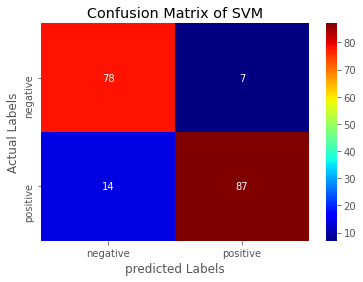

In [73]:
SVC_res=modelEvaluation(preds, y_test, 'SVM', classes)
collect_results_of_all_model["SVC"] = SVC_res

In [74]:
from sklearn.tree import DecisionTreeClassifier

DT_classifier = DecisionTreeClassifier(random_state=0)
DT_classifier.fit(X_train,y_train)

preds = DT_classifier.predict(X_test)

========== DT ==========

Accuracy on validation set: 0.9516

Classification report : 
              precision    recall  f1-score   support

   negative       0.96      0.93      0.95        85
   positive       0.94      0.97      0.96       101

avg / total       0.95      0.95      0.95       186



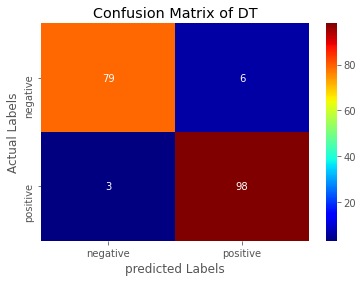

In [75]:
DT_res=modelEvaluation(preds, y_test, 'DT', classes)
collect_results_of_all_model["DT"] = DT_res

In [76]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(max_depth=5, bootstrap=100)
RF.fit(X_train,y_train)

preds_RF = RF.predict(X_test)

========== Random Forest ==========

Accuracy on validation set: 0.9785

Classification report : 
              precision    recall  f1-score   support

   negative       1.00      0.95      0.98        85
   positive       0.96      1.00      0.98       101

avg / total       0.98      0.98      0.98       186



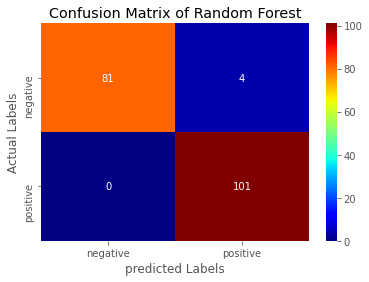

In [77]:
RF_res = modelEvaluation(preds_RF, y_test, 'Random Forest', classes)
collect_results_of_all_model["RF_CLassifier"] = RF_res

In [78]:
from sklearn.naive_bayes import GaussianNB

NB_classifier = GaussianNB()
NB_classifier.fit(X_train,y_train)

preds = NB_classifier.predict(X_test)

========== NB ==========

Accuracy on validation set: 0.6667

Classification report : 
              precision    recall  f1-score   support

   negative       1.00      0.27      0.43        85
   positive       0.62      1.00      0.77       101

avg / total       0.79      0.67      0.61       186



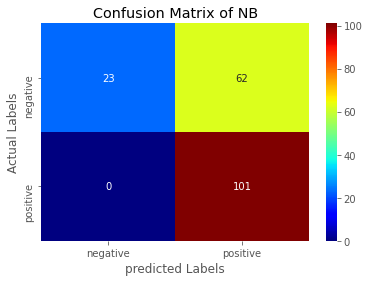

In [79]:
NB_res=modelEvaluation(preds, y_test, 'NB', classes)
collect_results_of_all_model["NB"] = NB_res

In [82]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train,y_train)

predictions = clf.predict(X_train)
print(accuracy_score(y_train, predictions))
preds = clf.predict(X_test)

1.0


========== Ada ==========

Accuracy on validation set: 0.9677

Classification report : 
              precision    recall  f1-score   support

   negative       0.98      0.95      0.96        85
   positive       0.96      0.98      0.97       101

avg / total       0.97      0.97      0.97       186



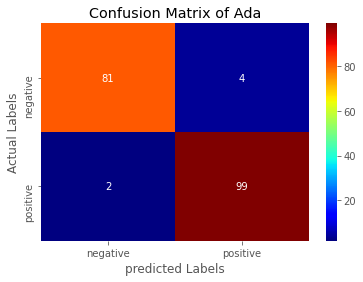

In [83]:
NB_res=modelEvaluation(preds, y_test, 'Ada', classes)
collect_results_of_all_model["Ada"] = NB_res

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train,y_train)

predictions = clf.predict(X_train)
print(accuracy_score(y_train, predictions))
preds = clf.predict(X_test)

0.9986486486486487


========== Gradient ==========

Accuracy on validation set: 0.9731

Classification report : 
              precision    recall  f1-score   support

   negative       0.99      0.95      0.97        85
   positive       0.96      0.99      0.98       101

avg / total       0.97      0.97      0.97       186



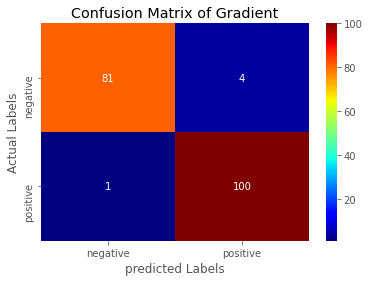

In [85]:
NB_res=modelEvaluation(preds, y_test, 'Gradient', classes)
collect_results_of_all_model["Gradient"] = NB_res

In [86]:
from tabulate import tabulate 
metrics_data_frame = pd.DataFrame(collect_results_of_all_model) # create dataframe
metrics_data_frame = metrics_data_frame.set_index('Metrics') # set index
metrics_data_frame

,Linear Regression,Logistic Regression,SVC,KNN,DT,RF_CLassifier,NB,Ada,Gradient
Metrics,,,,,,,,,
accuracy,0.903226,0.881720,0.887097,0.967742,0.951613,0.978495,0.666667,0.967742,0.973118
precision,0.903264,0.883634,0.886679,0.971963,0.952861,0.980952,0.809816,0.968534,0.974672
recall,0.901573,0.880972,0.889517,0.964706,0.949854,0.976471,0.635294,0.966570,0.971520
f1-score,0.902311,0.881378,0.886832,0.967284,0.951103,0.978243,0.595539,0.967437,0.972835


Text(0.5, 0, 'Evaluation Measure')

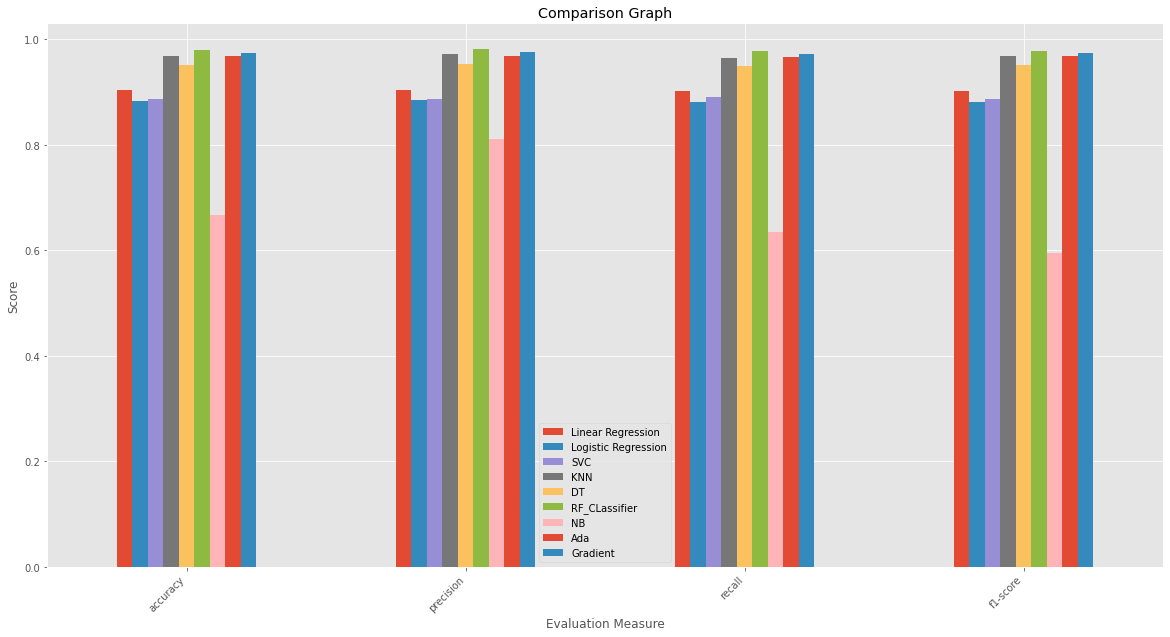

In [87]:
metrics_data_frame.plot(kind='bar', figsize=(20,10)) # sho comparison base of mertics
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Comparison Graph')
plt.ylabel('Score')
plt.xlabel("Evaluation Measure")